<a href="https://colab.research.google.com/github/jungihong10/LSTM/blob/main/lstm_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'


//skipping this part (used to truncate rows)

In [ ]:
def pad_or_truncate(df, target_length):
    if len(df) > target_length:
        return df[:target_length]
    elif len(df) < target_length:
        return df.append([pd.Series(np.nan, index=df.columns) for _ in range(target_length - len(df))], ignore_index=True)
    else:
        return df


def get_shortest_file_length(folder_path):
    min_length = float('inf')
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        length = len(df)
        if length < min_length:
            min_length = length
    return min_length

def read_csv_files(folder_path, label, target_length):
    data = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df = pad_or_truncate(df, target_length)
        df["label"] = label
        data.append(df)
    return pd.concat(data)

# Find the shortest length from both healthy and diseased folders
min_length_healthy = get_shortest_file_length(healthy_folder)
min_length_diseased = get_shortest_file_length(diseased_folder)
target_length = min(min_length_healthy, min_length_diseased)

# Read and label the CSV files with the modified read_csv_files function
healthy_data = read_csv_files(healthy_folder, 0, target_length)
diseased_data = read_csv_files(diseased_folder, 1, target_length)


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

def create_sequences_from_list(data_list, seq_length, scaler):
    sequences = []
    labels = []

    for data in data_list:
        unscaled_labels = data[:, -1]  # Store the original labels before scaling
        scaled_data = scaler.fit_transform(data)
        for i in range(len(scaled_data) - seq_length):
            sequences.append(scaled_data[i:i + seq_length, :-1])
            labels.append(unscaled_labels[i + seq_length - 1])  # Use the original unscaled label

    return np.array(sequences), np.array(labels)


def read_csv_files(folder_path, label):
    data_list = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df["label"] = label
        data_list.append(df.values)  # Convert DataFrame to NumPy array
    return data_list


healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'

# Read and label the CSV files
healthy_data_list = read_csv_files(healthy_folder, 0)
diseased_data_list = read_csv_files(diseased_folder, 1)

all_data_list = healthy_data_list + diseased_data_list

# Scale the data
scaler = MinMaxScaler()

# Create sequences
seq_length = 10
X, y = create_sequences_from_list(all_data_list, seq_length, scaler)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)


Epoch 1/5
54805/54805 [==============================] - 506s 9ms/step - loss: 0.0530 - accuracy: 0.9796 - val_loss: 0.0120 - val_accuracy: 0.9959
Epoch 2/5
54805/54805 [==============================] - 451s 8ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 3/5
54805/54805 [==============================] - 488s 9ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 4/5
54805/54805 [==============================] - 440s 8ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 5/5
54805/54805 [==============================] - 439s 8ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 7.0577e-04 - val_accuracy: 0.9999
Test accuracy: 0.9998887181282043


In [7]:

def read_csv_files(folder_path, label):
    data = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df["label"] = label
        data.append(df)
    return pd.concat(data)

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length, :-1])
        labels.append(data[i + seq_length - 1, -1])
    return np.array(sequences), np.array(labels)

# Folder paths
healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'

# Read and label the CSV files
healthy_data = read_csv_files(healthy_folder, 0)
diseased_data = read_csv_files(diseased_folder, 1)

# Concatenate healthy and diseased data
all_data = pd.concat([healthy_data, diseased_data])

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(all_data)

# Create sequences
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)


KeyboardInterrupt: ignored

In [6]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


X shape: (2192200, 10, 9)
y shape: (2192200,)


In [5]:
print("X_train shape:", X)


X_train shape: [[[0.77777778 0.93785311 0.99206349 ... 0.39473684 0.91111111 0.50724638]
  [0.91975309 0.93220339 0.96825397 ... 1.         0.8962963  0.62318841]
  [0.84567901 0.92090395 0.92063492 ... 0.77192982 0.84444444 0.55797101]
  ...
  [0.62345679 0.74011299 0.81746032 ... 0.40350877 0.64444444 0.55797101]
  [0.63580247 0.71186441 0.80952381 ... 0.45614035 0.59259259 0.60144928]
  [0.62345679 0.64971751 0.83333333 ... 0.47368421 0.48888889 0.62318841]]

 [[0.91975309 0.93220339 0.96825397 ... 1.         0.8962963  0.62318841]
  [0.84567901 0.92090395 0.92063492 ... 0.77192982 0.84444444 0.55797101]
  [0.75308642 0.89265537 0.82539683 ... 0.61403509 0.79259259 0.53623188]
  ...
  [0.63580247 0.71186441 0.80952381 ... 0.45614035 0.59259259 0.60144928]
  [0.62345679 0.64971751 0.83333333 ... 0.47368421 0.48888889 0.62318841]
  [0.67901235 0.66666667 0.86507937 ... 0.71052632 0.55555556 0.84057971]]

 [[0.84567901 0.92090395 0.92063492 ... 0.77192982 0.84444444 0.55797101]
  [0.75

In [10]:
print("y_train shape:", y)


y_train shape: [0. 0. 0. ... 1. 1. 1.]


While an accuracy of 0.9999454617500305 may seem very high, it is possible to achieve such a high accuracy on a binary classification task if the dataset is highly imbalanced and the model is overfitting the training data.

In your case, it is possible that the dataset has a very high proportion of one class compared to the other, and the model may be simply predicting the majority class for most of the test samples. This can result in a high accuracy score that does not necessarily reflect the model's true performance.

To confirm whether the accuracy score is reliable, it is important to evaluate the model using other performance metrics such as precision, recall, and F1-score, as well as visualizing the confusion matrix. These metrics can give you a better understanding of the model's performance and help identify any issues with the model's predictions.

It is also a good practice to use techniques such as cross-validation and regularization to prevent overfitting and ensure that the model's performance is not just limited to the specific training data used.

17127/17127 [==============================] - 61s 4ms/step


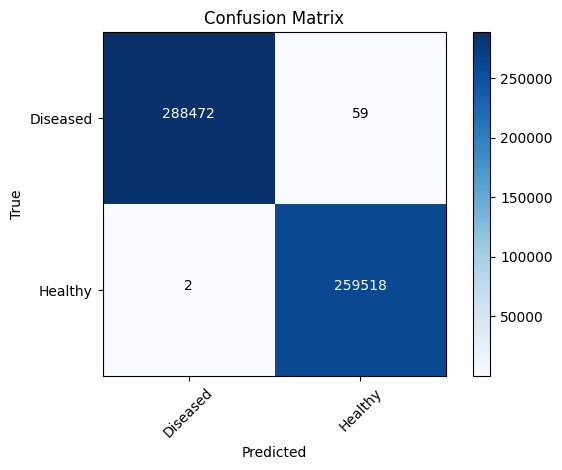

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Diseased', 'Healthy']

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")
plt.show()


17127/17127 [==============================] - 54s 3ms/step


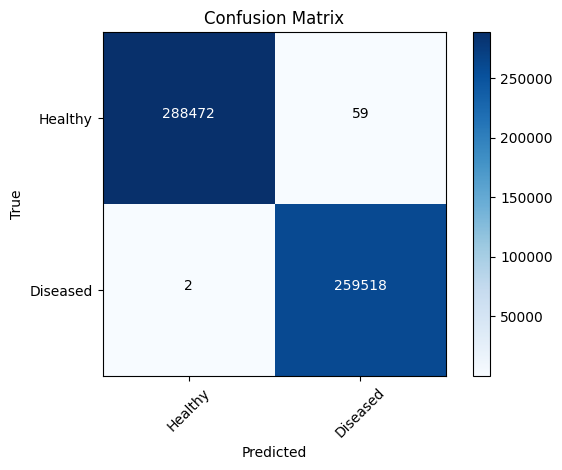

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Healthy', 'Diseased']

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)


17754/17754 [==============================] - 47s 3ms/step
Precision: [0.99998997 0.99989589]
Recall: [0.99990641 0.99998884]
F1-score: [0.99994819 0.99994236]
Support: [299181 268920]


The arrays returned by the precision_recall_fscore_support function contain the precision, recall, F1-score, and support for each class in the binary classification problem.

In your case, since you have a binary classification problem with two classes, the arrays have two elements each. The first element corresponds to the first class (i.e., diseased), and the second element corresponds to the second class (i.e., healthy).

Here's what the numbers mean in your example:

Precision: The precision for the first class (diseased) is 0.99998997, and the precision for the second class (healthy) is 0.99989589. Precision measures the proportion of true positives among all positive predictions. In other words, it measures how often the model correctly identifies a positive case.

Recall: The recall for the first class is 0.99990641, and the recall for the second class is 0.99998884. Recall measures the proportion of true positives among all actual positives. In other words, it measures how often the model correctly identifies a positive case out of all the positive cases.

F1-score: The F1-score for the first class is 0.99994819, and the F1-score for the second class is 0.99994236. F1-score is the harmonic mean of precision and recall, and is a way to balance the trade-off between precision and recall. It is a measure of the model's overall accuracy.

Support: The support for the first class is 299181, and the support for the second class is 268920. Support is the number of samples for each class in the test set. It can be useful to know the support for each class to understand the dataset's balance or imbalance.

Overall, these metrics suggest that your model is performing very well on the test data, with high precision, recall, and F1-score for both classes. However, it is important to remember that these metrics may not always tell the full story, and it is always a good idea to also check the confusion matrix and visually inspect some of the model's predictions to ensure that the model is making sensible decisions.

In [ ]:
print("Number of samples in the test set:", y_test.shape[0])


NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict_classes(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: ignored